<a href="https://colab.research.google.com/github/elliewalters-oss/Data-Science/blob/main/Foundations_of_DS_10_Feature_Engineering_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(readr)
library(dplyr)
library(forcats)

In [ ]:
system("gdown 1tg9T97GfwstlY1R5AamcDkJuDFM01oL5")

# Initial data preparation

In [ ]:
# Mutations on `lifeboat` and `fare` can be considered
# as feature engineering already.

d <- read_csv('/content/titanic.csv')
d <- d %>%
  select(-c(name, ticket, body_id_number)) %>%
  mutate(
    lifeboat = as_factor(if_else(is.na(lifeboat), "No", "Yes")),
    fare = if_else(fare == 0, NaN, fare),
    pclass = as_factor(pclass),
    sex = as_factor(sex),
    embarkment_port = as_factor(embarkment_port))

Rows: 1309 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): pclass, survived, name, sex, ticket, cabin, embarkment_port, lifeboat
dbl (5): age, siblings_and_spouses_onboard, parents_and_children_onboard, fa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Feature engineering in tibbles

Dplyr can be useful for performing some quick feature engineering.
However, if the computed feature for a given observation depends on other observations (which can potentially end up in the test/validation datasets), such a transformation can cause information leakage.
Such transformations should be done exclusively via the `recipes` package to prevent information leakage.

Another reason why you might want to use recipes instead of `dplyr` for feature engineering is that recipes do not modify the original data nor require that you make multiple copies of it.
This means that you can easily evaluate the impact of each transformation and even perform rigorous model selection on the combined transformation+prediction model.

Therefore, if the data will be used for a prediction task, I generally advise to use recipes.
Transform the data using `dplyr` only for preliminary analyses and to visualise the transformations.
However, I must be honest: the `recipes` package is not yet as developed, used, polished and easy to use as are `sklearn`'s pipelines.
Therefore, this might be an area in which Python users are at a slight advantage.

## Combining multiple features into one

Features can be combined to decrease their number, especially in case there are many independent variables compared to the dataset size.
For example, in the Titanic dataset, we might combine the `siblings_and_spouses_onboard` and the `parents_and_children_onboard` columns into a generic `family_size` column.
Because this combination is performed row-wise, no information leakage will happen.

In [ ]:
d_reduced <- d %>%
  mutate(family_size = siblings_and_spouses_onboard + parents_and_children_onboard) %>%
  select(-c(siblings_and_spouses_onboard, parents_and_children_onboard))

In [ ]:
d_reduced %>% head()

pclass,survived,sex,age,fare,cabin,embarkment_port,lifeboat,family_size
<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<dbl>
First,Yes,female,29.00,211.3375,B5,Southampton,Yes,0
First,Yes,male,0.92,151.5500,C22 C26,Southampton,Yes,3
First,No,female,2.00,151.5500,C22 C26,Southampton,No,3
First,No,male,30.00,151.5500,C22 C26,Southampton,No,3
First,No,female,25.00,151.5500,C22 C26,Southampton,No,3
First,Yes,male,48.00,26.5500,E12,Southampton,Yes,0


## Creating interaction terms

An interaction term is obtained by combining two existing features into a new one.
Usually, the features used in the interaction are not removed.
A typical example is to add product features that will then be fed to a linear model.
Because a linear model cannot represent any multiplicative interaction among features (unlike, e.g., a neural network), such features can be hand-crafted.

In the following example, we create an interaction feature between the `age` and `fare` columns.

In [ ]:
d_interaction <- d %>%
  mutate(age_fare_interaction = age * fare)

In [ ]:
d_interaction %>% head()

pclass,survived,sex,age,siblings_and_spouses_onboard,parents_and_children_onboard,fare,cabin,embarkment_port,lifeboat,age_fare_interaction
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<dbl>
First,Yes,female,29.00,0,0,211.3375,B5,Southampton,Yes,6128.788
First,Yes,male,0.92,1,2,151.5500,C22 C26,Southampton,Yes,139.426
First,No,female,2.00,1,2,151.5500,C22 C26,Southampton,No,303.100
First,No,male,30.00,1,2,151.5500,C22 C26,Southampton,No,4546.500
First,No,female,25.00,1,2,151.5500,C22 C26,Southampton,No,3788.750
First,Yes,male,48.00,0,0,26.5500,E12,Southampton,Yes,1274.400


## Numerical transformations

Depending on the distribution of a feature's value, it might useful to apply some numerical transformation to it.
For example, if the relationship between a feature and the label is close to exponential and we are using a linear regression model, we can take the logarithm of the feature.
Other times, we take the logarithm of and independent variable for a more prosaic reason: it can help the training algorithm converge faster.
For further references, please see [this CrossValidated thread](https://stats.stackexchange.com/questions/298).

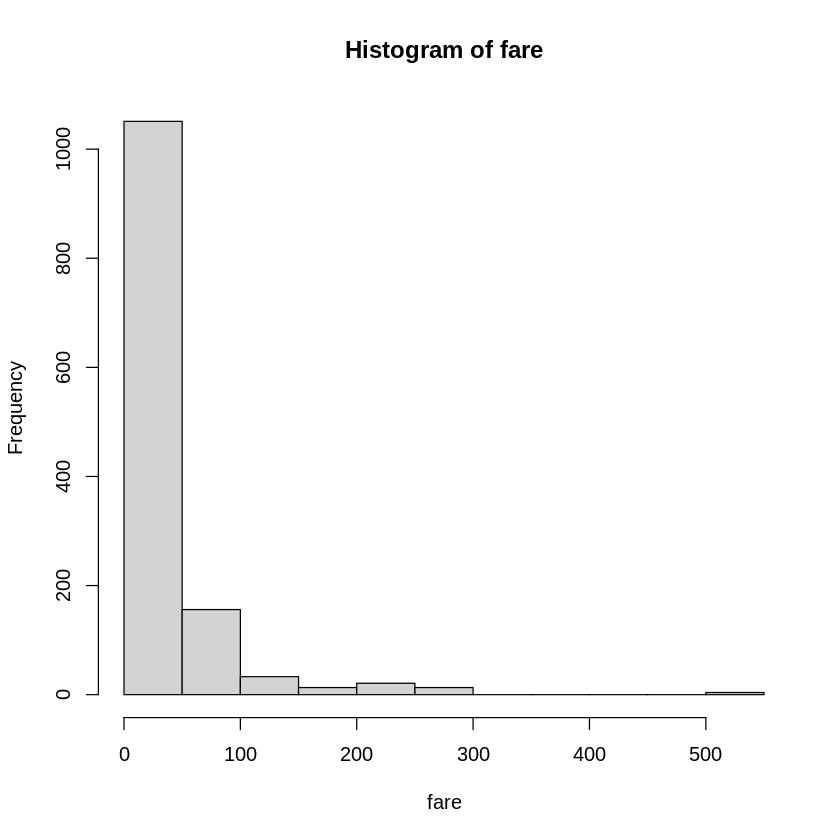

In [ ]:
d %>% with(hist(fare))

### Log transform

In [ ]:
d_logfare <- d %>%
  mutate(fare = log(fare))

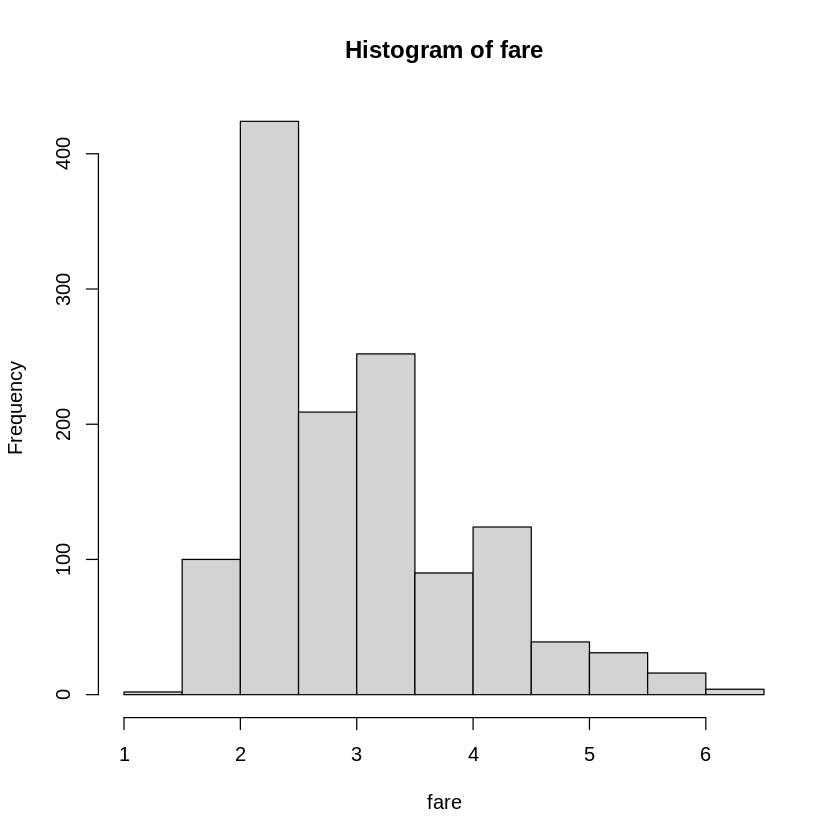

In [ ]:
d_logfare %>% with(hist(fare))

Other times, numerical instability can result from using features with values of very different magnitude.
For example, if some features have values of magnitude $10^6$ and others have values of magnitude $10^{-3}$.
In this case, one can apply transformations that reduce the range of the numeric variables.
In the process, one can also transform their distribution.
Such transformations can even be applied to the label and, in many case, increase the out-of-sample accuracy of machine learning models.

Virtually all these transformations use information computed on the entire dataset.
Therefore, they should always be used with `recipes` if the resulting data is used to train and validate a machine learning model.
The two most common transformations are:
* Standardisation, i.e., subtracting the mean from each value and then dividing by the standard deviation. In this case, when splitting our data into training and test set, the meand and the standard deviation should be computed *on the training data only* and then used for both training and test data. In R, you can use the `scale()` function to apply such transformation to a tibble's column.
* Quantile transforms map a feature's probability distribution into a known one, usually a normal pdf or a uniform pdf. This transformation relies on an estimation of the cdf of a given feature. Again, this estimation should only use training data and the estimated parameters can then be used on the training as well as the test data. In R, you can use the `rank()` function to apply such transformation to a tibble's column.

### Standardisation

In [ ]:
d_std_fare <- d %>%
  mutate(fare = scale(fare))

In [ ]:
d_std_fare %>% head()

pclass,survived,sex,age,siblings_and_spouses_onboard,parents_and_children_onboard,fare,cabin,embarkment_port,lifeboat
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>",<chr>,<fct>,<fct>
First,Yes,female,29.00,0,0,3.4183230,B5,Southampton,Yes
First,Yes,male,0.92,1,2,2.2675974,C22 C26,Southampton,Yes
First,No,female,2.00,1,2,2.2675974,C22 C26,Southampton,No
First,No,male,30.00,1,2,2.2675974,C22 C26,Southampton,No
First,No,female,25.00,1,2,2.2675974,C22 C26,Southampton,No
First,Yes,male,48.00,0,0,-0.1382683,E12,Southampton,Yes


### Quantile transform (normal distribution)

In [ ]:
library(stats)
d_norm_fare <- d %>%
  mutate(fare = qnorm(rank(fare, ties.method = "average") / (n() + 1)))

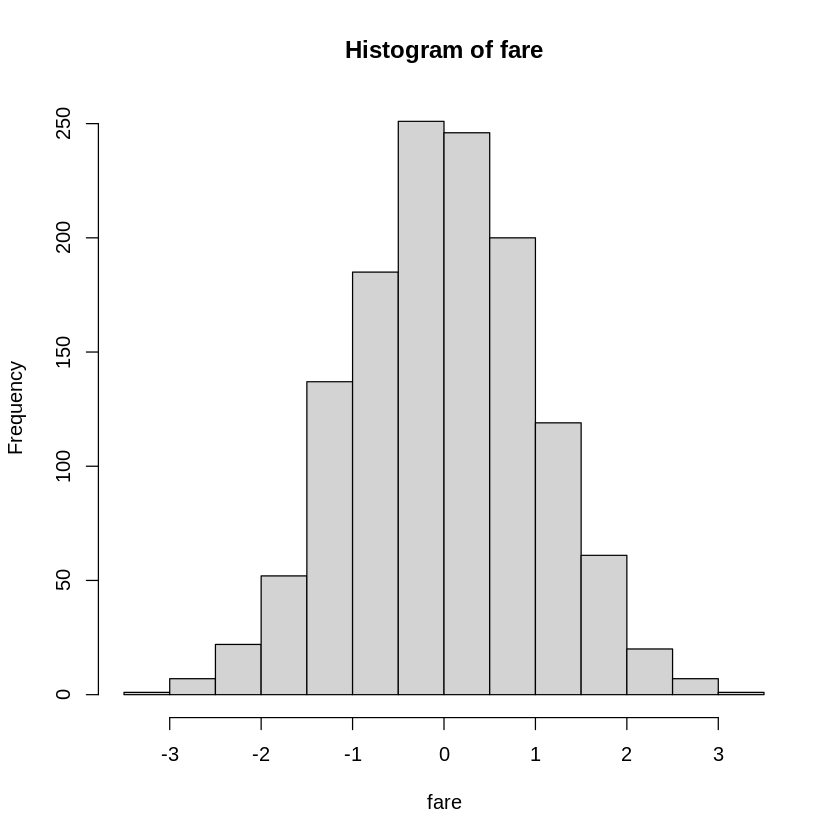

In [ ]:
d_norm_fare %>% with(hist(fare))

### Quantile transform (uniform distribution)

In [ ]:
d_unif_fare <- d %>%
  mutate(fare = rank(fare, ties.method = "average") / (n() + 1))

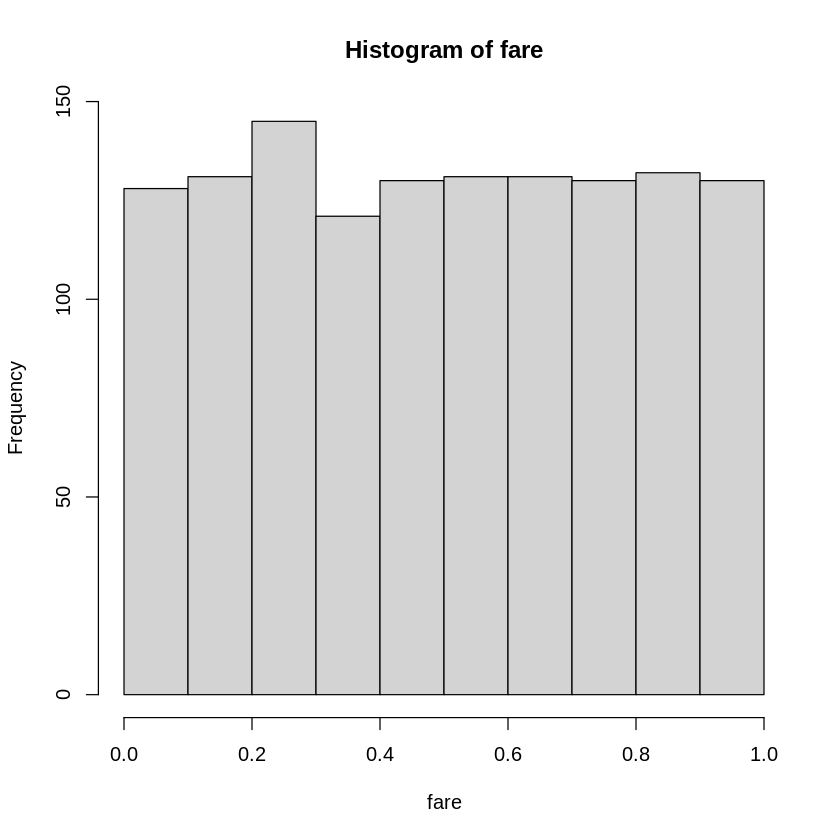

In [ ]:
d_unif_fare %>% with(hist(fare))

### Binning

Binning can refer to a couple of distinct procedures.

First, it can mean transforming a numeric feature into a categorical one, depending on value bins.
For example, we could bin the ages into 'Infant', 'Young', 'Middle-age', 'Elderly'.
This procedure is rarely useful and, in general, it tends to worsen the predictive power of a properly tuned and trained model.

Second, it can mean decreasing the number of categories of a categorical variable by merging some of them.
When a categorical variable has very high cardinality, this procedure can be useful.
For example, in our data, the cabin data has high cardinality.
However, when a cabin is present, it is composed of two parts: the deck, indicated by a letter, and the room number.
One can imagine that being on a lower deck would result in a lower probability of getting onboard a lifeboat.
Therefore, we could bin our cabins into decks.

In [ ]:
library(stringr)
d_deck <- d %>%
  mutate(deck = as_factor(str_extract(cabin, "[A-Z]"))) %>%
  select(-cabin)

In [ ]:
d_deck %>% head()

pclass,survived,sex,age,siblings_and_spouses_onboard,parents_and_children_onboard,fare,embarkment_port,lifeboat,deck
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
First,Yes,female,29.00,0,0,211.3375,Southampton,Yes,B
First,Yes,male,0.92,1,2,151.5500,Southampton,Yes,C
First,No,female,2.00,1,2,151.5500,Southampton,No,C
First,No,male,30.00,1,2,151.5500,Southampton,No,C
First,No,female,25.00,1,2,151.5500,Southampton,No,C
First,Yes,male,48.00,0,0,26.5500,Southampton,Yes,E


# Further references

* [The art of feature engineering](https://www.cambridge.org/core/books/the-art-of-feature-engineering/ABCC84474D629206F6FCA64AFAAA7A1A). Duboue, Pablo. Cambridge Press (2020).
* [Feature Engineering A–Z](https://feaz-book.com/). Hvitfeldt, Emil.